In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.model_selection import train_test_split


In [2]:
df=np.load(r'Data/creditcard.npy')
df=pd.DataFrame(df).sample(150000)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

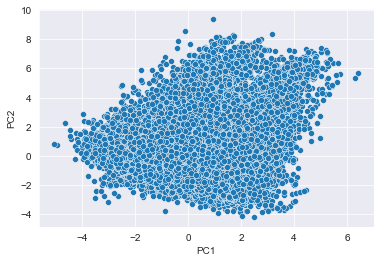

In [3]:
# do pca 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df.drop(columns=30))
df_pca = pca.transform(df.drop(columns=30))
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['PC1', 'PC2',]
# plot
sns.scatterplot(x='PC1', y='PC2', data=df_pca)


In [4]:
df=df_pca

In [5]:
# k means from scratch
class Kmeans:
    def __init__(self, n_clusters, max_iter=150, tol=1e-4):
        self.k = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels = None
        self.inertia = None
        self.n_iter = None

    def fit(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False), :]
        for i in range(self.max_iter):
            self.labels = np.argmin(
                np.sum((X[:, None, :]-self.centroids[None, :, :]) ** 2, axis=2),
                axis=1)
            new_centroids = np.array([
                X[self.labels == i].mean(axis=0) for i in range(self.k)])
            if np.sum((self.centroids - new_centroids) ** 2) < self.tol:
                break
            self.centroids = new_centroids
        self.inertia = np.sum((X - self.centroids[self.labels]) ** 2)
        self.n_iter = i + 1
        return self

    def predict(self, X):
        return np.argmin(np.sum((X[:, None, :] - self.centroids[None, :, :]) ** 2, axis=2), axis=1)

    def fit_predict(self, X):
        return self.fit(X).predict(X)

In [9]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
for i in range(2,10):
    kmeans = Kmeans(n_clusters=i)
    kmeans.fit(df.values)
    print(i, silhouette_score(df.values,
                              kmeans.predict(df.values),
                              sample_size=10000))

2 0.41710393557043474
3 0.4459280894891527
4 0.4008954160618073
5 0.3995349904774815
6 0.3688615310899512
7 0.34927693827206574
8 0.357534101931423
9 0.34594086276448827


1.872251272201538


C:\Users\No1\AppData\Local\Temp\ipykernel_18880\138162043.py:13: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.scatterplot(


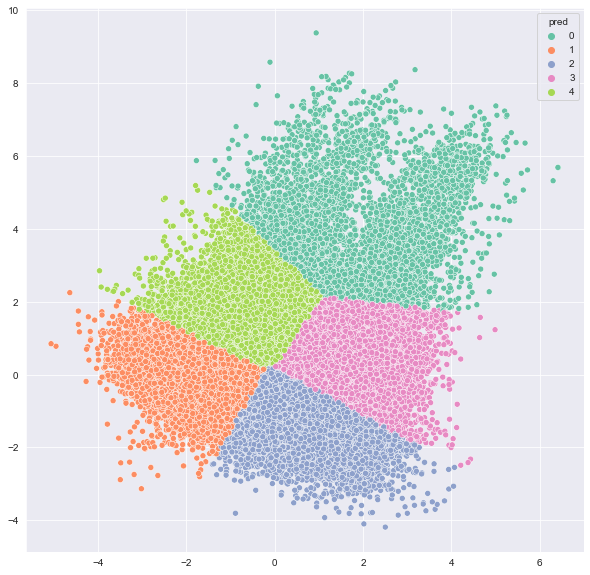

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)


<Figure size 720x720 with 0 Axes>

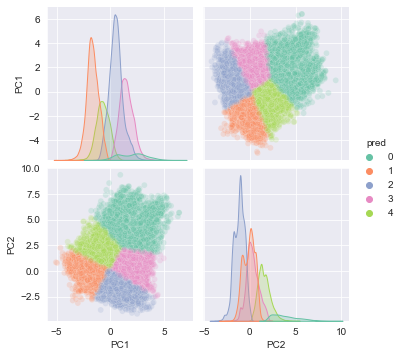

In [10]:
# tsne cluster plot with k=3
kmeans = Kmeans(n_clusters=5)
temp=df
# time the fit
start = time.time()
kmeans.fit(df.values)
end = time.time()
print(end-start)

temp['pred']=kmeans.predict(df.values)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=df.values[:,0], y=df.values[:,1], hue=temp['pred'],
    palette=sns.color_palette("Set2"))
plt.show()

plt.figure(figsize=(10,10))
sns.pairplot(temp, plot_kws={'alpha': 0.2}, hue='pred',
             palette=sns.color_palette("Set2"))
plt.show()

In [16]:
from scipy.stats import multivariate_normal


# Gaussian Mixture Model from scratch
class GMM:
    def __init__(self, n_clusters, max_iter=150, tol=1e-4):
        self.k = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.means = None
        self.covs = None
        self.weights = None
        self.labels = None
        self.n_iter = None

    def fit(self, X):
        n, d = X.shape
        self.means = X[np.random.choice(n, self.k, replace=False), :]
        self.covs = np.array([np.eye(d)] * self.k)
        self.weights = np.ones(self.k) / self.k
        for i in range(self.max_iter):
            # E-step
            probs = np.array([
                multivariate_normal.pdf(X, self.means[j], self.covs[j])
                for j in range(self.k)
            ]).T
            probs = probs * self.weights
            probs = probs / probs.sum(axis=1, keepdims=True)
            # M-step
            self.weights = probs.sum(axis=0) / n
            self.means = (probs.T @ X) / probs.sum(axis=0, keepdims=True).T
            self.covs = np.array([
                (probs[:, j][:, None] * (X - self.means[j])).T @ (X - self.means[j]) / probs[:, j].sum()
                for j in range(self.k)
            ])
            if np.sum((self.means - self.means) ** 2) < self.tol:
                break
        self.labels = np.argmax(probs, axis=1)
        self.n_iter = i + 1
        return self

    def predict(self, X):
        probs = np.array([
            multivariate_normal.pdf(X, self.means[j], self.covs[j])
            for j in range(self.k)
        ]).T
        probs = probs * self.weights
        probs = probs / probs.sum(axis=1, keepdims=True)
        return np.argmax(probs, axis=1)

    def fit_predict(self, X):
        return self.fit(X).predict(X)

In [17]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
for i in range(2,10):
    kmeans = GMM(n_clusters=i)
    kmeans.fit(df.values)
    print(i, silhouette_score(df.values,
                              kmeans.predict(df.values),
                              sample_size=10000))

2 0.3571519051394968
3 0.35088107333378676
4 0.3312762643743478
5 0.4982284001315061
6 0.3838816295651036
7 0.3944737360450135
8 0.32108424672675756
9 0.36027785099164433


0.07290291786193848


C:\Users\No1\AppData\Local\Temp\ipykernel_18880\1326391511.py:13: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.scatterplot(


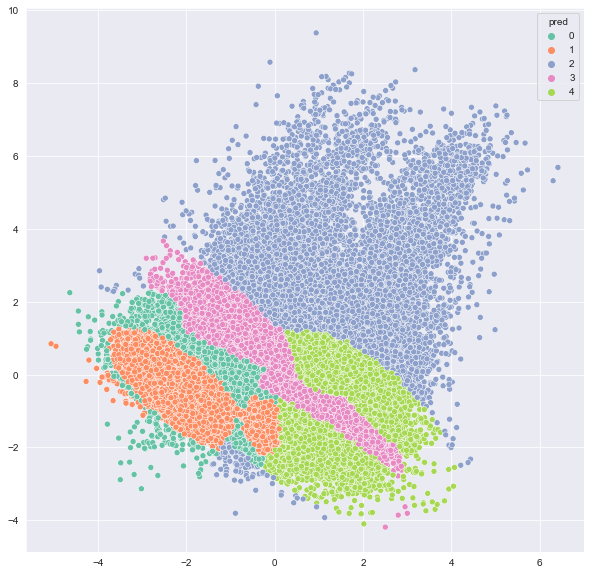

E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)
E:\User Applications\Software\Miniconda3\envs\SpikingJelly\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)


<Figure size 720x720 with 0 Axes>

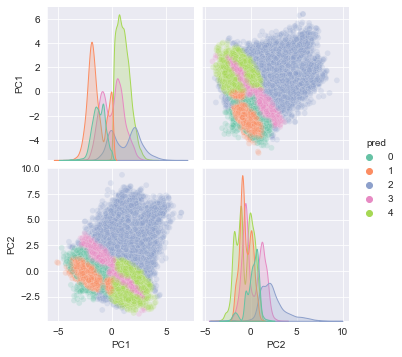

In [19]:
# tsne cluster plot with k=3
kmeans = GMM(n_clusters=5, max_iter=1000)
temp=df

start = time.time()
kmeans.fit(df.values)
end = time.time()
print(end-start)

temp['pred']=kmeans.predict(df.values)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=df.values[:,0], y=df.values[:,1], hue=temp['pred'],
    palette=sns.color_palette("Set2"))
plt.show()

plt.figure(figsize=(10,10))
sns.pairplot(temp, plot_kws={'alpha': 0.2}, hue='pred',
             palette=sns.color_palette("Set2"))
plt.show()